# Predicting the Past, United States Extension (Decay on) 

## Introduction
This is an add on of Predicting the Past, United States Extension where decay is now turned on. 
This add on includes comparisons between _CYCLUS_ output and CURIE data for the United States from 1968 to 2013 where decay is turned on for: 
 - Total spent fuel mass 
 - Mass of major isotopes in spent fuel 

The CURIE data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

Decay was turned on by adding 10 storage facilities to the input xml file that each take in consecutive ~ 5 years of spent fuel (with exception to 1st storage facility that takes ~ 10 years and 10th that takes everything after 2014) and outputs the spent fuel at year 2020. 

Most of the subsequent code is copied from united_states_extention.ipynb

** Import necessary libraries ** 

In [386]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
from collections import defaultdict
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import operator
import re 
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 

sys.path.append('../../../scripts/')
import analysis as an

** Run Cyclus simulation **

In [ ]:
!rm cyclus/united_states_decayon_underestm_33.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_33.xml -o ./cyclus/united_states_decayon_underestm_33.sqlite --warn-limit 0

** Setting up to analyze sqlite file ** 

In [25]:
# Before this step, must download the output sqlite files from the fuel-cycles box. 
# fuel-cycle/cyclus_output/predicting_the_past_validation 
# and put into a directory named cyclus 

def get_cursor(file_name):
    """ Connects and returns a cursor to an sqlite output file

    Parameters
    ----------
    file_name: str
        name of the sqlite file

    Returns
    -------
    sqlite cursor
    """
    con = lite.connect(file_name)
    con.row_factory = lite.Row
    return con.cursor()


cursor_51 = get_cursor('cyclus/united_states_decayon_underestm.sqlite')
cursor_33 = get_cursor('cyclus/united_states_decayon_underestm_33.sqlite')

In [26]:
def get_timesteps(cur):
    """ Returns simulation start year, month, duration and
    timesteps (in numpy linspace).

    Parameters
    ----------
    cur: sqlite cursor
        sqlite cursor

    Returns
    -------
    init_year: int
        start year of simulation
    init_month: int
        start month of simulation
    duration: int
        duration of simulation
    timestep: list
        linspace up to duration
    """
    info = cur.execute('SELECT initialyear, initialmonth, '
                       'duration FROM info').fetchone()
    init_year = info['initialyear']
    init_month = info['initialmonth']
    duration = info['duration']
    timestep = np.linspace(0, duration - 1, num=duration)

    return init_year, init_month, duration, timestep

** Get total spent fuel produced after cooling in spent fuel pool until 2020** 

In [27]:
def total_spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
        
        init_yr, init_month, duration, timestep = get_timesteps(cur)
        spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                                 'INNER JOIN resources '
                                 'ON transactions.resourceid = resources.resourceid '
                                 'WHERE Commodity =:cool_spent_uox' # must specify isotope and pool
                                 ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox}).fetchall()
        spent_fuel_list = an.get_timeseries(spent_fuel,duration,True)
        spent_fuel_total = np.sum(spent_fuel_list)
        total_list.append(spent_fuel_total)
        
    total_cum = np.cumsum(total_list)
    return total_cum 

total_spentfuel_33 = total_spent_fuel_produced(cursor_33)
total_spentfuel_51 = total_spent_fuel_produced(cursor_51)

** Get specific isotope composition from total spent fuel produced after cooling in spent fuel pool until 2020** 

In [ ]:
def isotope_total_cum(cur,num,in_dict):
    """ Find total isotopes present in spent fuel output by reactor for each cooling pool and sum cumulatively 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    num: nucid 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors added cumulatively for each cooling pool
    """    
    
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    isotope_total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
    
        init_yr, init_month, duration, timestep = get_timesteps(cur)
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity =:cool_spent_uox AND nucid =:num ' # must specify isotope and pool
                               ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox, "num":num}).fetchall()
        isotope_list = an.get_timeseries(isotopes,duration,True)
        isotope_total = np.sum(isotope_list)
        isotope_total_list.append(isotope_total)
    
    isotope_total_cum = np.cumsum(isotope_total_list)
    #print(isotope_total_cum)
    name = nn.name(num)
    #print(name)
    in_dict[name] = isotope_total_cum
    #print(dict_51)
    return

In [ ]:
# To create dictionaries of burn up 51 and 33 (this takes a whole day to run)
dict_51 = {}
nucnum = [20040000, 882260000, 882280000, 822060000, 822070000, 822080000, 822100000, 902280000, 902290000, 902300000, 902320000, 832090000, 892270000, 912310000, 922320000, 922330000, 922340000, 922350000, 922360000, 922380000, 932370000, 942380000, 942390000, 942400000, 942410000, 942420000, 942440000, 952410000, 952420001, 952430000, 962420000, 962430000, 962440000, 962450000, 962460000, 962470000, 962480000, 962500000, 982490000, 982500000, 982510000, 982520000, 10030000, 60140000, 360810000, 360850000, 380900000, 430990000, 531290000, 551340000, 551350000, 551370000]
for x in range(0,52):
    num = nucnum[x]
    print(x)
    isotope_total_cum(cursor_51,num,dict_51)
    
dict_33 = {}
for x in range(0,52):
    num = nucnum[x]
    print(x)
    isotope_total_cum(cursor_33,num,dict_33)

In [ ]:
# To avoid running ipynb for whole day, the output of previously ran ipynb are stored. 

In [1]:
# get required libraries 
try:
    import cPickle as pickle 
except ImportError: 
    import pickle 

In [19]:
# To store 
with open('dict_51.p','wb') as fp:
    pickle.dump(dict_51,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# To store 
with open('dict_33.p','wb') as fp:
    pickle.dump(dict_33,fp,protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# To load into this notebook
with open('dict_51.p', 'rb') as fp:
    dict_51 = pickle.load(fp)

In [8]:
# To load into this notebook
with open('dict_33.p', 'rb') as fp:
    dict_33 = pickle.load(fp)

## CURIE Data Analysis 

In [14]:
names = ['assembly_id','reactor_id', 'reactor_type', 'initial_uranium_kg','initial_enrichment','discharge_burnup','discharge_date','discharge_time','total_assembly_decay_heat_kw','name','evaluation_date','total_mass_g','total_radioactivity_curies']
df = pd.read_csv('SNF_nuclide_2020_07_01.dat',
                  sep='\s+',
                  index_col=False, 
                  names = names)

In [15]:
date_isotope_mass = df[['discharge_date','name','total_mass_g']]
date_mass = df[['discharge_date','total_mass_g']]

In [16]:
spent_fuel_mass = date_mass.groupby('discharge_date').sum()
spent_fuel_mass_cum = spent_fuel_mass.cumsum()
spent_fuel_mass_cum['total_mass_g'] = spent_fuel_mass_cum['total_mass_g'].apply(lambda x: x*0.000001)
spent_fuel_mass_cum = spent_fuel_mass_cum.rename(columns = {'total_mass_g':'total_mass_MTHM_CURIE'})
spent_fuel_mass_cum.index.names = ['discharge_date']

In [17]:
CURIE_isotope = date_isotope_mass.pivot_table(index='discharge_date',columns='name',aggfunc=sum)
CURIE_isotope_cum_all = CURIE_isotope.cumsum()

In [18]:
pd.set_option('display.max_columns',None)
isotope_list = list(CURIE_isotope_cum_all)
curie_isotope_list = [x[1] for x in isotope_list]

In [349]:
spent_fuel_mass_cum.index[1670]

'2010-01-11'

## Relative Error 

In [364]:
def error_total(cyclus_list,pool,absolute): 
    """ Find relative error between the total spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    cyclus_list: array of cumulative spent fuel mass 
    
    Returns 
    -------
    relative errors in percentage of spent fuel mass in 2014
    """   

    curie_list = spent_fuel_mass_cum.values
    cyclus_2014 = cyclus_list[pool-1] 
    
    curie = [64, 234, 429, 670, 922, 1167, 1417, 1670, -1] # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
    curie_2014 = curie_list[curie[pool-1]]
    #print(cyclus_2014)
    #print(curie_2014)
    
    if absolute: 
        error= (cyclus_2014-curie_2014)
    else: 
        error= ((cyclus_2014-curie_2014)/curie_2014)*100
    #print(error)
    return error     

In [365]:
# Total relative and absolute error is the same for both burn ups
total_relative_error_1=error_total(total_spentfuel_33,1,False) #1975
total_relative_error_2=error_total(total_spentfuel_33,2,False) #1980
total_relative_error_3=error_total(total_spentfuel_33,3,False) #1985
total_relative_error_4=error_total(total_spentfuel_33,4,False) #1990
total_relative_error_5=error_total(total_spentfuel_33,5,False) #1995
total_relative_error_6=error_total(total_spentfuel_33,6,False) #2000
total_relative_error_7=error_total(total_spentfuel_33,7,False) #2005
total_relative_error_8=error_total(total_spentfuel_33,8,False) #2010
total_relative_error_9=error_total(total_spentfuel_33,9,False) #2014

total_absolute_error_1=error_total(total_spentfuel_33,1,True)
total_absolute_error_2=error_total(total_spentfuel_33,2,True)
total_absolute_error_3=error_total(total_spentfuel_33,3,True)
total_absolute_error_4=error_total(total_spentfuel_33,4,True)
total_absolute_error_5=error_total(total_spentfuel_33,5,True)
total_absolute_error_6=error_total(total_spentfuel_33,6,True)
total_absolute_error_7=error_total(total_spentfuel_33,7,True)
total_absolute_error_8=error_total(total_spentfuel_33,8,True)
total_absolute_error_9=error_total(total_spentfuel_33,9,True)

In [366]:
def isotope_error(in_dict,pool,absolute): 
    """ Find relative or absolute error between the total isotopes present in spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    in_dict = dictionary of isotopes and their corresponding cumilative spent fuel mass 
    pool = int of pool number you want to compare isotopes at 
    
    Returns 
    -------
    relative errors in percentage of the specified isotope for burn up of 51 and 33 GWd/tHM in 2014 in a dictionary 
    """    
    isotope_names = ['He4', 'Ra226', 'Ra228', 'Pb206', 'Pb207', 'Pb208', 'Pb210', 'Th228', 'Th229', 'Th230', 'Th232', 'Bi209', 'Ac227', 'Pa231', 'U232', 'U233', 'U234', 'U235', 'U236', 'U238', 'Np237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu244', 'Am241', 'Am242M', 'Am243', 'Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246', 'Cm247', 'Cm248', 'Cm250', 'Cf249', 'Cf250', 'Cf251', 'Cf252', 'H3', 'C14', 'Kr81', 'Kr85', 'Sr90', 'Tc99', 'I129', 'Cs134', 'Cs135', 'Cs137']
    error_isotope = {}
    for x in range(0,52): 
        cyclus_2014 = in_dict[isotope_names[x]][pool-1]
        curie = [64, 234, 429, 670, 922, 1167, 1417, 1670, -1] # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
        #print(cyclus_2014)
        element_name = isotope_names[x]
        element_name = element_name.lower()
        match = re.match(r"([a-z]+)([0-9]+)", element_name, re.I)
        if match:
            items = match.groups()
            #print(items)
        num_name = items[0]+ "-" + items[1]
        #print(num_name)
        if any (num_name in s for s in curie_isotope_list):
            if num_name == 'am-242':
                curie_list = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'am-242m')]
                curie_list = curie_list.to_frame()
                curie_list = curie_list.multiply(0.000001)
                curie_list = curie_list.values

                curie_2014 = curie_list[curie[pool-1]]
                if absolute: 
                    error = (cyclus_2014-curie_2014)
                else: 
                    error = ((cyclus_2014-curie_2014)/curie_2014)*100
                error_isotope[element_name] = error  
            else: 
                curie_list = CURIE_isotope_cum_all.loc[:,('total_mass_g', num_name)]
                curie_list = curie_list.to_frame()
                curie_list = curie_list.multiply(0.000001)
                curie_list = curie_list.values

                curie_2014 = curie_list[curie[pool-1]]
                if absolute: 
                    error = (cyclus_2014-curie_2014)
                else: 
                    error = ((cyclus_2014-curie_2014)/curie_2014)*100
                error_isotope[element_name] = error 
        #else: 
            #print(num_name,'does not exist in curie data')
    return error_isotope  

In [367]:
relative_error_isotope_51_1 = isotope_error(dict_51,1,False)
relative_error_isotope_51_2 = isotope_error(dict_51,2,False)
relative_error_isotope_51_3 = isotope_error(dict_51,3,False)
relative_error_isotope_51_4 = isotope_error(dict_51,4,False)
relative_error_isotope_51_5 = isotope_error(dict_51,5,False)
relative_error_isotope_51_6 = isotope_error(dict_51,6,False)
relative_error_isotope_51_7 = isotope_error(dict_51,7,False)
relative_error_isotope_51_8 = isotope_error(dict_51,8,False)
relative_error_isotope_51_9 = isotope_error(dict_51,9,False)

relative_error_isotope_33_1 = isotope_error(dict_33,1,False)
relative_error_isotope_33_2 = isotope_error(dict_33,2,False)
relative_error_isotope_33_3 = isotope_error(dict_33,3,False)
relative_error_isotope_33_4 = isotope_error(dict_33,4,False)
relative_error_isotope_33_5 = isotope_error(dict_33,5,False)
relative_error_isotope_33_6 = isotope_error(dict_33,6,False)
relative_error_isotope_33_7 = isotope_error(dict_33,7,False)
relative_error_isotope_33_8 = isotope_error(dict_33,8,False)
relative_error_isotope_33_9 = isotope_error(dict_33,9,False)

In [289]:
absolute_error_isotope_51_4 = isotope_error(dict_51,4,True)
absolute_error_isotope_51_5 = isotope_error(dict_51,5,True)
absolute_error_isotope_51_6 = isotope_error(dict_51,6,True)
absolute_error_isotope_51_9 = isotope_error(dict_51,9,True)

absolute_error_isotope_33_4 = isotope_error(dict_33,4,True)
absolute_error_isotope_33_5 = isotope_error(dict_33,5,True)
absolute_error_isotope_33_6 = isotope_error(dict_33,6,True)
absolute_error_isotope_33_9 = isotope_error(dict_33,9,True)

In [380]:
absolute_error_isotope_51_4['pu242']

array([ 15.82441805])

In [394]:
def isotope_error_list(in_dict): 
    """ Finds absolute error between the total isotopes present in spent fuel output for 9 time steps for cyclus and udb data 
    # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
    
    Parameters 
    ----------
    in_dict = dictionary of isotopes and their corresponding cumilative spent fuel mass  
    
    Returns 
    -------
    Dictionary of of errors of each specified isotope in the 9 time steps 
    """  
    dict_isotopes =  defaultdict(list)
    for x in range(0,9): 
        isotope_dict = isotope_error(in_dict,x,True)
        for key in isotope_dict:
            specific_isotope_dict = isotope_dict[key]
            #print(specific_isotope_dict)
            dict_isotopes[key].append(specific_isotope_dict)
    return dict_isotopes

In [397]:
dict_51_isotopes_list = isotope_error_list(dict_51)
dict_33_isotopes_list = isotope_error_list(dict_33)

In [494]:
# dict of spent fuel information 
# taken from: https://www.eia.gov/nuclear/spent_fuel/ussnftab3.php
dict_spentfuel_eia =  defaultdict(list)
dict_average_burn_up =  defaultdict(list)
# 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
dict_spentfuel_eia['1975'] = [164.9,299.4,17.2,17.4]
dict_spentfuel_eia['1980'] = [564.9,617.6,22.3,29.8]
dict_spentfuel_eia['1985'] = [542.6,859.7,23.6,32.0]
dict_spentfuel_eia['1990'] = [681.1,1480.8,25.4,34.6]
dict_spentfuel_eia['1995'] = [780.6,1627.3,32.8,40.9]
dict_spentfuel_eia['2000'] = [800.4,1368.0,38.3,44.9]
dict_spentfuel_eia['2005'] = [707.0,1626.0,42.8,46.6]
dict_spentfuel_eia['2010'] = [820.9,1250.9,44.3,46.8]
dict_spentfuel_eia['2014'] = [575.5,665.8,44.1,45.4]
for key in dict_spentfuel_eia: 
    dict_average_burn_up[key] = (dict_spentfuel_eia[key][0]*dict_spentfuel_eia[key][2]+dict_spentfuel_eia[key][1]*dict_spentfuel_eia[key][3])/(dict_spentfuel_eia[key][0]+dict_spentfuel_eia[key][1])
dict_average_burn_up

defaultdict(list,
            {'1975': 17.32896833943571,
             '1980': 26.21712473572939,
             '1985': 28.7497397133281,
             '1990': 31.701568065127894,
             '1995': 38.27411852651688,
             '2000': 42.46380741560597,
             '2005': 45.448435490784405,
             '2010': 45.8094362390192,
             '2014': 44.79728510432611})

In [517]:
dict_cum_burn_up =  defaultdict(list)
dict_cum_burn_up['1975'] = 16.95151515
dict_cum_burn_up['1980'] = 22.33243684
dict_cum_burn_up['1985'] = 25.3447386
dict_cum_burn_up['1990'] = 27.15992636
dict_cum_burn_up['1995'] = 30.15556123
dict_cum_burn_up['2000'] = 32.7058552
dict_cum_burn_up['2005'] = 35.15625665
dict_cum_burn_up['2010'] = 37.00594291
dict_cum_burn_up['2014'] = 37.7196081
dict_cum_burn_up

defaultdict(list,
            {'1975': 16.95151515,
             '1980': 22.33243684,
             '1985': 25.3447386,
             '1990': 27.15992636,
             '1995': 30.15556123,
             '2000': 32.7058552,
             '2005': 35.15625665,
             '2010': 37.00594291,
             '2014': 37.7196081})

In [522]:
def plot_burn_up_differences(in_dict,burn_up):
    dict_average_burn_up_diff =  defaultdict(list)
    for key in in_dict: 
        dict_average_burn_up_diff[key] = burn_up-(in_dict[key])
    
    plt.bar(dict_average_burn_up_diff.keys(), dict_average_burn_up_diff.values(), width = 0.5, color='g')
    return 

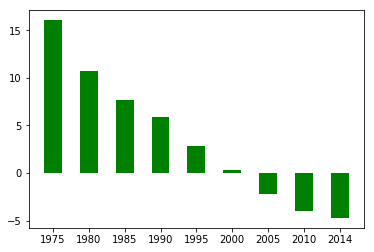

In [523]:
plot_burn_up_differences(dict_cum_burn_up,33)

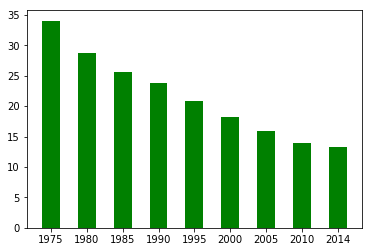

In [524]:
plot_burn_up_differences(dict_cum_burn_up,51)

In [504]:
def plot_isotope_error_list(isotope):
    dates = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(dates,dict_51_isotopes_list[isotope],color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
    ax.scatter(dates,dict_33_isotopes_list['pu242'],color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
    box = ax.get_position()
    ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
    ax.set_ylabel('Absolute error', fontsize=18)
    ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for %s' % isotope, fontsize=17)
    plt.savefig('figures/absolute_error_%s.png' % isotope, bbox_inches="tight")

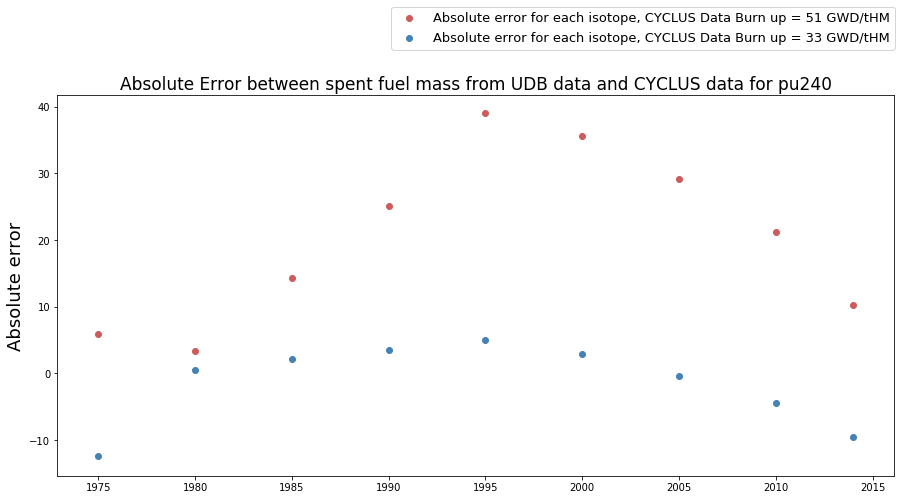

In [515]:
plot_isotope_error_list('pu240')

In [368]:
def sort_error(in_list_sort,in_list_copy):
    """ Sort in_list_copy based on the first column in_list_sort 
    
    Parameters 
    ----------
    in_list_sort = list with 2 columns. First is isotope names, second is their relative error in percentage 
    in_list_copy = list with 2 columns. First is isotope names, second is their relative error in percentage 
    
    Returns 
    -------
    in_list_copy with its list rearranged to follow the first column in in_list_sort  
    
    """
    sorted_sort = sorted(in_list_sort.items(),key=operator.itemgetter(1))
    sorted_copy = sorted(in_list_copy.items(),key=operator.itemgetter(1))
    values_copy_sorted = []
    length1 = len(sorted_sort)
    length2 = len(sorted_copy)
    for x in range(0,length1):
        keys_sort = sorted_sort[x][0]
        for y in range(0,length2): 
            keys_copy = sorted_copy[y][0]
            if keys_sort == keys_copy: 
                values_copy_sorted.append(sorted_copy[y])
                break
    return sorted_sort,values_copy_sorted

In [369]:
sorted_relative_error_isotope_51_9, sorted_relative_error_isotope_33_9 = sort_error(relative_error_isotope_51_9,relative_error_isotope_33_9)
sorted_relative_error_isotope_51_6, sorted_relative_error_isotope_33_6 = sort_error(relative_error_isotope_51_6,relative_error_isotope_33_6)
sorted_relative_error_isotope_51_5, sorted_relative_error_isotope_33_5 = sort_error(relative_error_isotope_51_5,relative_error_isotope_33_5)
sorted_relative_error_isotope_51_4, sorted_relative_error_isotope_33_4 = sort_error(relative_error_isotope_51_4,relative_error_isotope_33_4)

In [370]:
sorted_absolute_error_isotope_51_9, sorted_absolute_error_isotope_33_9 = sort_error(absolute_error_isotope_51_9,absolute_error_isotope_33_9)
sorted_absolute_error_isotope_51_6, sorted_absolute_error_isotope_33_6 = sort_error(absolute_error_isotope_51_6,absolute_error_isotope_33_6)
sorted_absolute_error_isotope_51_5, sorted_absolute_error_isotope_33_5 = sort_error(absolute_error_isotope_51_5,absolute_error_isotope_33_5)
sorted_absolute_error_isotope_51_4, sorted_absolute_error_isotope_33_4 = sort_error(absolute_error_isotope_51_4,absolute_error_isotope_33_4)

** Plot of relative error for each isotope at year 2000 **

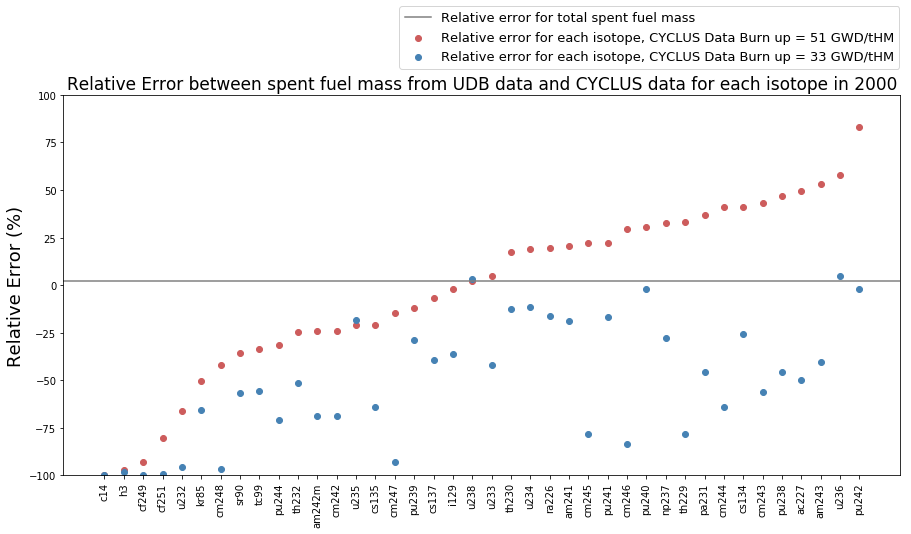

In [438]:
# arranging variables 
x = list(list(zip(*sorted_relative_error_isotope_51_6))[0])
y1 = list(list(zip(*sorted_relative_error_isotope_51_6))[1])
y2 = list(list(zip(*sorted_relative_error_isotope_33_6))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=total_relative_error_6,color='grey',label='Relative error for total spent fuel mass')
ax.scatter(y_pos,y1,color = 'indianred', label='Relative error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Relative error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-100,top=100)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Relative Error (%)', fontsize=18)
ax.set_title('Relative Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 2000', fontsize=17)
plt.savefig('figures/relative_error_2000.png', bbox_inches="tight")

** Plot of relative error for each isotope at year 2014 **

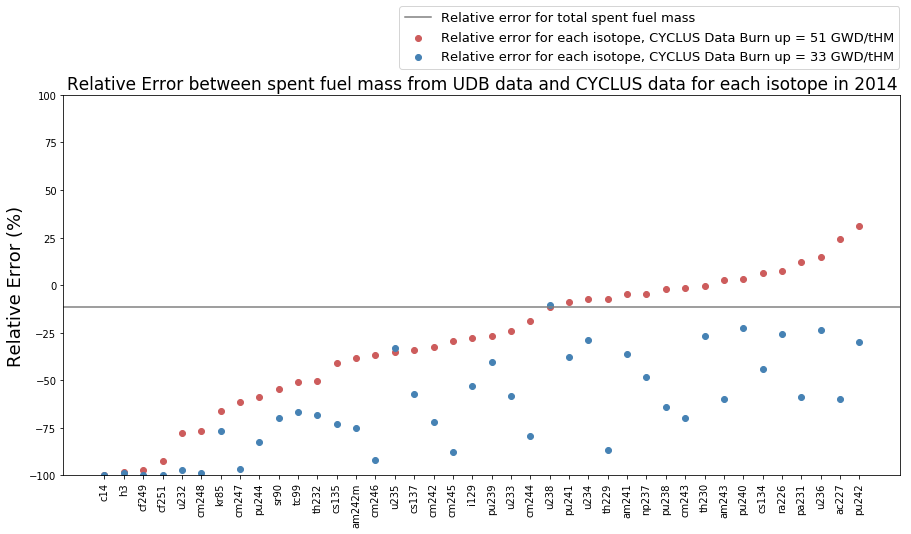

In [439]:
# arranging variables 
x = list(list(zip(*sorted_relative_error_isotope_51_9))[0])
y1 = list(list(zip(*sorted_relative_error_isotope_51_9))[1])
y2 = list(list(zip(*sorted_relative_error_isotope_33_9))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=total_relative_error_9,color='grey',label='Relative error for total spent fuel mass')
ax.scatter(y_pos,y1,color = 'indianred', label='Relative error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Relative error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-100,top=100)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Relative Error (%)', fontsize=18)
ax.set_title('Relative Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 2014', fontsize=17)
plt.savefig('figures/relative_error_2014.png', bbox_inches="tight")

** Plot of absolute error for each isotope at year 2000 **

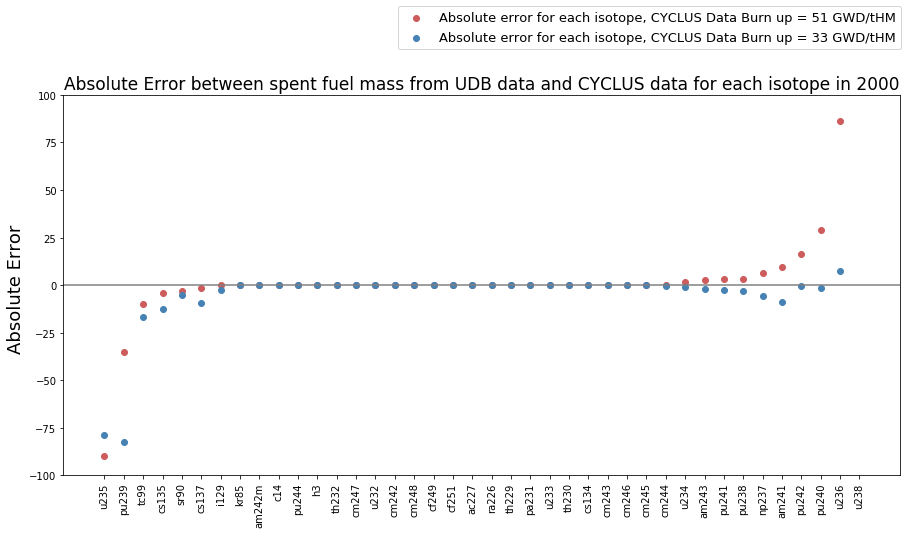

In [440]:
# arranging variables 
x = list(list(zip(*sorted_absolute_error_isotope_51_6))[0])
y1 = list(list(zip(*sorted_absolute_error_isotope_51_6))[1])
y2 = list(list(zip(*sorted_absolute_error_isotope_33_6))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=0,color='grey')
ax.scatter(y_pos,y1,color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-100,top=100)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Absolute Error ', fontsize=18)
ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 2000', fontsize=17)
plt.savefig('figures/absolute_error_2000.png', bbox_inches="tight")

In [441]:
# above plot 
# If dot is above the centre line, that isotope has more of 

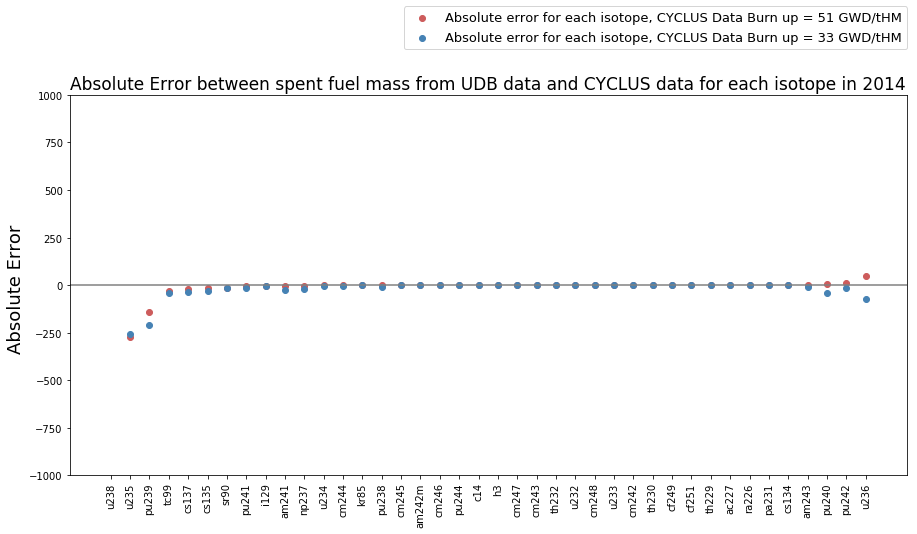

In [448]:
# arranging variables 
x = list(list(zip(*sorted_absolute_error_isotope_51_9))[0])
y1 = list(list(zip(*sorted_absolute_error_isotope_51_9))[1])
y2 = list(list(zip(*sorted_absolute_error_isotope_33_9))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=0,color='grey')
ax.scatter(y_pos,y1,color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-1000,top=1000)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Absolute Error ', fontsize=18)
ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 2014', fontsize=17)
plt.savefig('figures/absolute_error_2014.png', bbox_inches="tight")

** Plot of absolute error for each isotope at year 1995 **

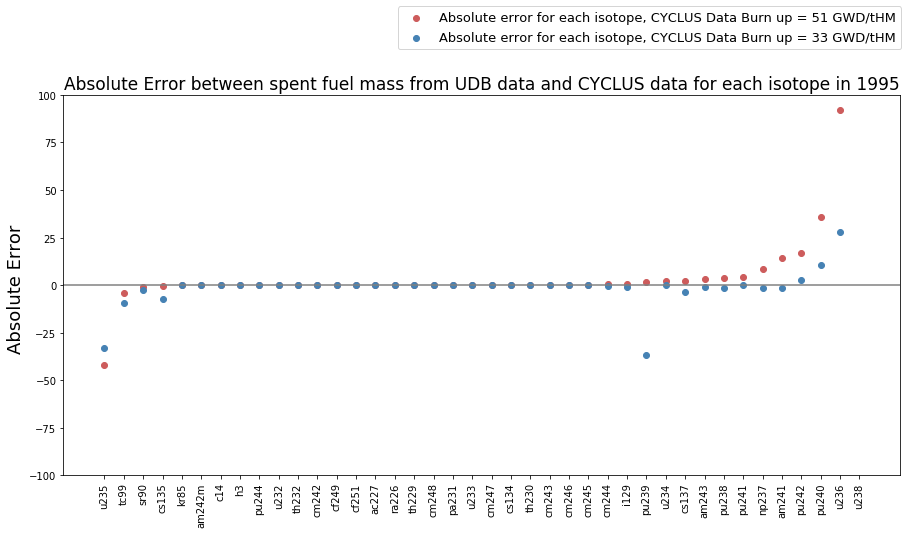

In [443]:
# arranging variables 
x = list(list(zip(*sorted_absolute_error_isotope_51_5))[0])
y1 = list(list(zip(*sorted_absolute_error_isotope_51_5))[1])
y2 = list(list(zip(*sorted_absolute_error_isotope_33_5))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=0,color='grey')
ax.scatter(y_pos,y1,color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-100,top=100)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Absolute Error ', fontsize=18)
ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 1995', fontsize=17)
plt.savefig('figures/absolute_error_1995.png', bbox_inches="tight")

** Plot of absolute error for each isotope at year 1990 **

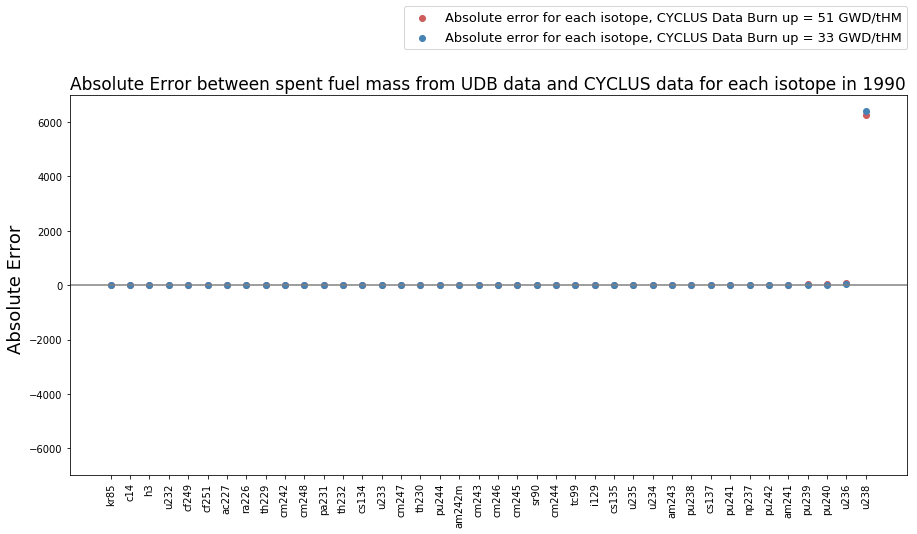

In [444]:
# arranging variables 
x = list(list(zip(*sorted_absolute_error_isotope_51_4))[0])
y1 = list(list(zip(*sorted_absolute_error_isotope_51_4))[1])
y2 = list(list(zip(*sorted_absolute_error_isotope_33_4))[1])
y_pos = np.arange(len(x))

# plot 
fig, ax = plt.subplots(figsize=(15,7))
plt.axhline(y=0,color='grey')
ax.scatter(y_pos,y1,color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWD/tHM', marker = "o")
ax.scatter(y_pos,y2,color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWD/tHM', marker = "o")
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.set_ylim(bottom=-7000,top=7000)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
ax.set_ylabel('Absolute Error ', fontsize=18)
ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for each isotope in 1990', fontsize=17)
plt.savefig('figures/absolute_error_1990_zoomout.png', bbox_inches="tight")

[-7879.52229021] #2014
[ 893.03061689] #2000
[ 3795.13876464] #1995
[ 6494.75006854] #1990